Лучшая попытка:

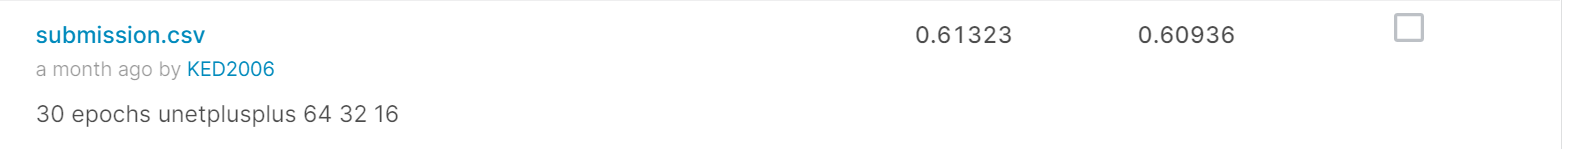

In [ ]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm

Считывание данных:

In [ ]:

path = '../input/tgcovid/data/data' 
path_images = os.path.join(path, 'images')
path_labels = os.path.join(path, 'labels')
with open('../input/tgcovid/training_data.json', 'r') as f:
    dict_training = json.load(f)

images = []
labels = []
for entry in tqdm(dict_training):
    s1 = os.path.join(path_images, entry['image'])
    sp1 = s1[:len(s1) - 3]

    s2 = os.path.join(path_labels, entry['label'])
    sp2 = s2[:len(s2) - 3]
    image = nib.load(sp1)
    label = nib.load(sp2)
    images.append(image.get_fdata().astype(np.float32))
    labels.append(label.get_fdata().astype(np.float32))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 0
slices_num = [10, 20, 30]
slices = []
for idx in slices_num:
    continue
    slices.append(blend(
        images[patient_num][..., idx],
        labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    continue
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

plt.show()

Сами рисунки:

In [ ]:
patient_num = 0
slices_num = [10, 20, 30]
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        0 * labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
import torch 
import torch.nn as nn
from torchvision import transforms

In [ ]:
import matplotlib.pyplot as plt

sample_image = torch.tensor(images[0], dtype = torch.float32)

sample_image.shape

Создадим датасет для обработки данных:

Без случайного флипа картинки(понадобится для реккурентного UNet)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class ImageDatasetWithoutTransforms(Dataset):
    def __init__(self, labels, images, train):
        super().__init__()
        self.labels = []
        self.images = []
        self.train = train
        
        for i in range(len(images)):
            images_tensor = torch.FloatTensor(images[i]).permute(2, 0, 1)
            if train:
                labels_tensor = torch.FloatTensor(labels[i]).permute(2, 0, 1)
            self.images.append([])
            self.labels.append([])
            for j in range(images_tensor.shape[0]):
                self.images[-1].append(images_tensor[j].reshape(1, 512, 512))
                if train:
                    self.labels[-1].append(labels_tensor[j].reshape(1, 512, 512))



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.train:
            return {"images" : self.images[index],
                    "labels" : self.labels[index]}
        else:
            return {"images" : self.images[index]}
    

In [ ]:
#transformer = transforms.Compose([])

datasetRnn = ImageDatasetWithoutTransforms(labels, images, True)
#dataset[0]

Разделение на train/test:

In [ ]:
train_size = len(datasetRnn) - 2
test_size = len(datasetRnn) - train_size

datasetRnnTrain, datasetRnnVal = torch.utils.data.random_split(datasetRnn, [train_size, test_size])

С аугментацией:

In [ ]:
from torch.utils.data import DataLoader, Dataset

class ImageDataset(Dataset):
    def __init__(self, labels, images, transforms):
        super().__init__()
        self.labels = []
        self.images = []
        self.transforms = transforms

        for i in range(len(images)):
            images_tensor = torch.FloatTensor(images[i]).permute(2, 0, 1)
            if self.transforms is not None:
                labels_tensor = torch.FloatTensor(labels[i]).permute(2, 0, 1)
            for j in range(images_tensor.shape[0]):
                self.images.append(images_tensor[j].reshape(1, 512, 512))
                if self.transforms is not None:
                    self.labels.append(labels_tensor[j].reshape(1, 512, 512))



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.transforms is not None:
            tens = torch.cat((self.images[index], self.labels[index]), 0)
            tens1 = self.transforms(tens)
            return {"images" : tens1[0],
                    "labels" : tens1[1]}
        else:
            return {"images" : self.images[index]}
    

In [ ]:
transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

dataset = ImageDataset(labels, images, transformer)
dataset[0]

Разделение на train/test

In [ ]:
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size

datasetTrain, datasetVal = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
from torch.utils.data import DataLoader

dataloaderTrain = DataLoader(datasetTrain, shuffle = True, batch_size = 2, pin_memory=False, num_workers = 0)
dataloaderVal = DataLoader(datasetVal, shuffle = True, batch_size = 2, pin_memory=False, num_workers = 0)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01),
        )

    def forward(self, X):
        return self.module(X)


class BlockConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01),
        )

    def forward(self, X):
        #print(X.shape)
        return self.model(X)

In [ ]:
class ReBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.module = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01),
        )

    def forward(self, X):
        return self.module(X)


class ReBlockConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01),
        )

    def forward(self, X):
        #print(X.shape)
        return self.model(X)

Модели:

Модель 1: Обычный UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels = 1):
        super().__init__()
        self.conv1 = nn.Sequential(
                  BlockConv2(in_channels, 16),
                  BlockConv2(16, 16), 
                  Block(16, 16)
        )
        self.pool1 = nn.MaxPool2d(4, 2, 1, return_indices=True)
        self.conv2 = nn.Sequential(
                BlockConv2(16, 8),
                BlockConv2(8, 8), 
                Block(8, 8)
        )     
        self.pool2 = nn.MaxPool2d(4, 2, 1, return_indices=True)
        self.conv3 = Block(8, 8)

        self.unpool1 = nn.MaxUnpool2d(4, 2, 1)

        self.up1 = nn.Sequential(
                nn.Upsample(scale_factor = 2, mode='nearest'),
                Block(8, 8),
                nn.Upsample(scale_factor = 2, mode='nearest'),
                Block(8, 16)
        )
        self.unpool2 = nn.MaxUnpool2d(4, 2, 1)

        self.up2 = nn.Sequential(
                nn.Upsample(scale_factor= 2, mode='nearest'),
                Block(16, 16),
                nn.Upsample(scale_factor= 2, mode='nearest'),
                Block(16, 3)
        )
        self.last = nn.Sequential(
            Block(4, 9),
            Block(9, 6),
            nn.Conv2d(6, 1, 3, 1, 1)
        )
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
    def forward(self, X):
        hidden = self.conv1(X)
        hidden, ind1 = self.pool1(hidden) 
        hidden = self.conv2(hidden) 
        hidden = self.dropout(hidden)
        hidden, ind2 = self.pool2(hidden) 
        hidden = self.conv3(hidden) 
       
        hidden = self.dropout(hidden)
        hidden = self.unpool1(hidden, ind2)
        hidden = self.up1(hidden) 
        hidden = self.dropout(hidden)
        hidden = self.unpool2(hidden, ind1)
        hidden = self.up2(hidden)
        hidden = torch.cat((hidden, X), 1)
        return self.sigmoid(self.last(hidden))

Модель 2: Реккурентный UNet

In [ ]:
from copy import deepcopy

class RNNUNet(nn.Module):
    def __init__(self, in_channels = 1):
        super().__init__()
        self.conv1 = nn.Sequential(
                  BlockConv2(in_channels, 32),
                  BlockConv2(32, 32), 
                  Block(32, 128)
        )
        self.pool1 = nn.MaxPool2d(4, 2, 1, return_indices=True)
        self.conv2 = nn.Sequential(
                BlockConv2(256, 256),#
                BlockConv2(256, 256), 
                Block(256, 256)
        )     
        self.pool2 = nn.MaxPool2d(4, 2, 1, return_indices=True)
        self.conv3 = Block(512, 256)#

        self.unpool1 = nn.MaxUnpool2d(4, 2, 1)

        self.up1 = nn.Sequential(
                nn.Upsample(scale_factor = 2, mode='nearest'),
                Block(256, 256),
                nn.Upsample(scale_factor = 2, mode='nearest'),
                Block(256, 128)
        )
        self.unpool2 = nn.MaxUnpool2d(4, 2, 1)

        self.up2 = nn.Sequential(
                nn.Upsample(scale_factor= 2, mode='nearest'),
                Block(128, 128),
                nn.Upsample(scale_factor= 2, mode='nearest'),
                Block(128, 128)
        )
        self.last = nn.Sequential(
            Block(129, 9),
            Block(9, 3),
            nn.Conv2d(3, 1, 3, 1, 1)
        )
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
    def forward(self, X, hidden):
        output = self.conv1(X)
        output, ind1 = self.pool1(output)
        newhidden1 = output
        output = self.conv2(torch.cat((output, hidden[0]), 1)) 
        output = self.dropout(output)
        output, ind2 = self.pool2(output) 
        newhidden2 = output
        output = self.conv3(torch.cat((output, hidden[1]), 1)) 
       
        output = self.dropout(output)
        output = self.unpool1(output, ind2)
        output = self.up1(output) 
        output = self.dropout(output)
        output = self.unpool2(output, ind1)
        output = self.up2(output)
        output = torch.cat((output, X), 1)
        return self.sigmoid(self.last(output)), (newhidden1, newhidden2)
    def init_hidden(self):
        return torch.zeros((1, 128, 64, 64)).to(device), torch.zeros((1, 256, 8, 8)).to(device)

Модель 3: UNetPlusPlus:

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import segmentation_models_pytorch as smp

class UnetikPlus(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.UnetPlusPlus(in_channels = 1, encoder_depth=3, decoder_channels=[ 64,32, 16]).to(device)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        output = self.model(X)
        return self.sigmoid(output)

Обучение:
1.UNet:

In [ ]:
model = UNet().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss() # тут так получилось, что на нем получается больше score

In [ ]:
from tqdm.auto import tqdm 

num_epochs = 1 # здесь это для демонстрации результатов, так надо обучать примерно в 30-40 эпох
model.train()
criterion_test = smp.losses.DiceLoss(mode = 'binary')

for i in tqdm(range(num_epochs)):
    sum_, cnt = 0, 0
    for batch in tqdm(dataloaderTrain):
        optimizer.zero_grad()
        images = batch['images'].to(device).reshape(-1, 1, 512, 512)
        labels = batch['labels'].to(device).reshape(-1, 1, 512, 512)
        #print(images.shape)
        model.train()
        output = model(images)
        loss = criterion(output, labels)
        sum_ += loss.item()
        cnt += 1
        loss.backward()
        optimizer.step()
    sum_test, cnt_test = 0, 0
    for batch in tqdm(dataloaderVal):
        with torch.no_grad():
            model.eval()
            images = batch['images'].to(device).reshape(-1, 1, 512, 512)
            labels = batch['labels'].to(device).reshape(-1, 1, 512, 512)
            output = model(images)
            sum_test += criterion_test(output, labels)
            cnt_test += 1
            
    print(f'Train loss : {sum_ / cnt}, test loss : {sum_test / cnt_test}')

Обучение примерно в 20 эпох дает скор 55-57

2. Обучение UNetPlusPlus:

In [ ]:
model2 = UnetikPlus().to(device)

In [ ]:
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3)
criterion = nn.BCELoss() # тут так получилось, что на нем получается больше score

In [ ]:
from tqdm.auto import tqdm 

num_epochs = 1 # здесь это для демонстрации результатов, так надо обучать примерно в 30-40 эпох
model2.train()

criterion_test = smp.losses.DiceLoss(mode = 'binary')

for i in tqdm(range(num_epochs)):
    sum_, cnt = 0, 0
    for batch in tqdm(dataloaderTrain):
        optimizer.zero_grad()
        images = batch['images'].to(device).reshape(-1, 1, 512, 512)
        labels = batch['labels'].to(device).reshape(-1, 1, 512, 512)
        #print(images.shape)
        model2.train()
        output = model2(images)
        loss = criterion(output, labels)
        sum_ += loss.item()
        cnt += 1
        loss.backward()
        optimizer.step()
    sum_test, cnt_test = 0, 0
    for batch in tqdm(dataloaderVal):
        with torch.no_grad():
            model2.eval()
            images = batch['images'].to(device).reshape(-1, 1, 512, 512)
            labels = batch['labels'].to(device).reshape(-1, 1, 512, 512)
            output = model2(images)
            sum_test += criterion_test(output, labels)
            cnt_test += 1
            
    print(f'Train loss : {sum_ / cnt}, test loss : {sum_test / cnt_test}')

Обучение примерно в 30 эпох дает скор примерно 60-62

3. Обучение RNNUNet

In [ ]:
model = RNNUNet().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss()

In [ ]:
from tqdm.auto import tqdm 

num_epochs = 1 # здесь это для демонстрации результатов, так надо обучать примерно в 30-40 эпох
model.train()
for epoch in tqdm(range(num_epochs)):
    sum_e, cnt = 0, 0
    for i in tqdm(range(len(datasetRnnTrain))):
        hidden = model.init_hidden()
        for j in range(len(datasetRnnTrain[i]['images'])):
            #print(images[j])
            optimizer.zero_grad()
            model.zero_grad()
            output, hidden = model(datasetRnnTrain[i]['images'][j].reshape(1, 1, 512, 512).to(device), (hidden[0].detach(), hidden[1].detach()))
            loss = criterion(output, datasetRnnTrain[i]['labels'][j].reshape(1, 1, 512, 512).to(device))
            sum_e += loss.item()
            cnt += 1
            loss.backward()
            optimizer.step()
            
    sum_t, cnt_t = 0, 0
    for i in tqdm(range(len(datasetRnnVal))):
        hidden = model.init_hidden()
        for j in range(len(datasetRnnVal[i]['images'])):
            #print(images[j])
            output, hidden = model(datasetRnnVal[i]['images'][j].reshape(1, 1, 512, 512).to(device), (hidden[0].detach(), hidden[1].detach()))
            loss = criterion(output, datasetRnnVal[i]['labels'][j].reshape(1, 1, 512, 512).to(device))
            sum_t += loss.item()
            cnt_t += 1
            
    
            
    
    print(f"Mean train loss per epoch is {sum_e / cnt}")

Обучаем ~40 эпох и получаем скор примерно 55-57

Submission для UNetPlusPlus(так как оно дало лучший скор)

In [ ]:
model2.eval()
with open('../input/tgcovid/testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testig = []
for entry in tqdm(dict_testing):
    s1 = os.path.join(path_images, entry['image'])
    sp1 = s1[:len(s1) - 3]

    image = nib.load(sp1)
    images_testig.append(image.get_fdata().astype(np.float32))

In [ ]:
lens_test = []
for i in range(len(images_testig)):
    lens_test.append(np.array(images_testig[i]).shape[2])

lens_test

In [ ]:
test_data = ImageDataset(None, images_testig, None)

In [ ]:
labels_predicted = []

model2.eval()
for batch in test_data:
    images = batch['images'].to(device).reshape(-1, 1, 512, 512)
    output = model2(images).reshape(512, 512, 1)
    labels_predicted.append(output.cpu().detach().numpy())

In [ ]:
answer_predicted = [] 

alpha = 0.5 # больше чем alpha считаем как 1, иначе 0. Этот параметр подкручиваем пока не получится хорошо xD

it = 0
last_cat = True

lens_test = []
for i in range(len(images_testig)):
    lens_test.append(np.array(images_testig[i]).shape[2])


for i in range(len(labels_predicted)):
    if last_cat:
        answer_predicted.append(labels_predicted[i])
        lens_test[it] -= 1
        last_cat = False
    else:
        answer_predicted[len(answer_predicted) - 1] = np.concatenate(( answer_predicted[len(answer_predicted) - 1], labels_predicted[i]), 2)
        lens_test[it] -= 1
        if lens_test[it] == 0:
            it += 1
            last_cat = True

            answer_predicted[len(answer_predicted) - 1] = answer_predicted[len(answer_predicted) - 1] > alpha
            answer_predicted[len(answer_predicted) - 1] = answer_predicted[len(answer_predicted) - 1].astype(np.int)
for i in range(len(answer_predicted)):
    print(answer_predicted[i].shape)

In [ ]:
for i in range(len(answer_predicted)):
    print(answer_predicted[i].shape)

In [ ]:
labels_predicted = answer_predicted

import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open(os.path.join("", '../input/tgcovid/testing_data.json'), 'r') as f:
    dict_testing = json.load(f)

with open(f'submission_{alpha}.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])

In [ ]:
import pandas as pd 

df_sub = pd.read_csv(f"submission_{alpha}.csv")
df_sub